## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import math
import os
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MovieLens Latest Small

In [ ]:
# Data Citation:
# F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on 
# Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. 

! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3836k      0 --:--:-- --:--:-- --:--:-- 3836k


In [ ]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
# import the dataset
df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [ ]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## MovieLens 100K

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2023-04-26 13:49:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.72MB/s    in 0.8s    

2023-04-26 13:49:48 (5.72 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
import zipfile
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
# import the dataset
df = pd.read_csv(
    "data/ml-100k/u.data",
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"],
    encoding='latin-1',
    engine='python'
) 

'''
df_train = pd.read_csv(
    "data/ml-100k/u1.base",
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"],
    encoding='latin-1',
    engine='python'
) 

df_test = pd.read_csv(
    "data/ml-100k/u1.test",
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"],
    encoding='latin-1',
    engine='python'
) 
'''

'\ndf_train = pd.read_csv(\n    "data/ml-100k/u1.base",\n    sep="\t",\n    names=["userId", "movieId", "rating", "timestamp"],\n    encoding=\'latin-1\',\n    engine=\'python\'\n) \n\ndf_test = pd.read_csv(\n    "data/ml-100k/u1.test",\n    sep="\t",\n    names=["userId", "movieId", "rating", "timestamp"],\n    encoding=\'latin-1\',\n    engine=\'python\'\n) \n'

In [ ]:
df

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## MovieLens 1M

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2023-04-27 14:17:29--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.42MB/s    in 1.6s    

2023-04-27 14:17:31 (3.42 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [4]:
import zipfile
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [5]:
# import the dataset
df = pd.read_csv(
    "data/ml-1m/ratings.dat",
    sep="::",
    names=["userId", "movieId", "rating", "timestamp"],
    encoding='latin-1',
    engine='python'
)

In [6]:
df

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Data Preparation

In [7]:
# create convertable continous unique values starting from 0
users = df.userId.unique()
movies = df.movieId.unique()

movieId_to_i = {}
i_to_movieId = {}
userId_to_i = {}
i_to_userId = {}

for (i, movieId) in enumerate(sorted(movies)):
    movieId_to_i[movieId] = i
    i_to_movieId[i] = movieId

for (i, userId) in enumerate(sorted(users)):
    userId_to_i[userId] = i
    i_to_userId[i] = userId

In [ ]:
# Create 9724 movieId x 610 ratings userId matrix
data = df.pivot_table(index='movieId', columns='userId', values='rating')

# create continous rows and column 0
data1 = data.reset_index(drop=True)

# Make userId start from 0
data2 = data1.rename(columns=dict(zip(data1.columns, list(range(len(data1.columns))))))

data2

userId,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
1,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train = data2.copy()

# Set test set to empty array of size 9724 x 610 
test = pd.DataFrame(np.empty(train.shape))
test[:] = np.nan

In [ ]:
da = df.copy()
da['userId'] = da['userId'].replace(userId_to_i)
da['movieId'] = da['movieId'].replace(movieId_to_i)

In [ ]:
# randomly choose 20% of rows for the test set
df_train, df_test = model_selection.train_test_split(
    da, test_size=0.1, random_state=42
)

'''
df_test = df.sample(n=round(len(df) * 0.2), random_state=42)
df_test 
'''

'''
# Move 20 percent of ratings for each user from train set to test set
for idx, column in data2.iteritems():
    not_null_column = column[column.notna()]
    num_to_replace = int(round(len(not_null_column) * 0.2))
    replace_indices = np.random.choice(not_null_column.index, size=num_to_replace, replace=False)

    for ind in replace_indices:
        test.iloc[ind,idx] = train.iloc[ind,idx]
        train.iloc[ind,idx] = float("nan")
'''

'\n# Move 20 percent of ratings for each user from train set to test set\nfor idx, column in data2.iteritems():\n    not_null_column = column[column.notna()]\n    num_to_replace = int(round(len(not_null_column) * 0.2))\n    replace_indices = np.random.choice(not_null_column.index, size=num_to_replace, replace=False)\n\n    for ind in replace_indices:\n        test.iloc[ind,idx] = train.iloc[ind,idx]\n        train.iloc[ind,idx] = float("nan")\n'

In [ ]:
'''
df_train['userId'] = df['userId'].replace(userId_to_i)
df_train['movieId'] = df['movieId'].replace(movieId_to_i)

df_test['userId'] = df['userId'].replace(userId_to_i)
df_test['movieId'] = df['movieId'].replace(movieId_to_i)
'''

In [ ]:
for idx, column in df_test.iterrows():
    test[column['userId']][column['movieId']] = train[column['userId']][column['movieId']]
    train[column['userId']][column['movieId']] = float("nan")

In [ ]:
for idx, column in df_test.iterrows():
    test[userId_to_i[column['userId']]][movieId_to_i[column['movieId']]] = train[userId_to_i[column['userId']]][movieId_to_i[column['movieId']]]
    train[userId_to_i[column['userId']]][movieId_to_i[column['movieId']]] = float("nan")


In [ ]:
test

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


KeyboardInterrupt: ignored

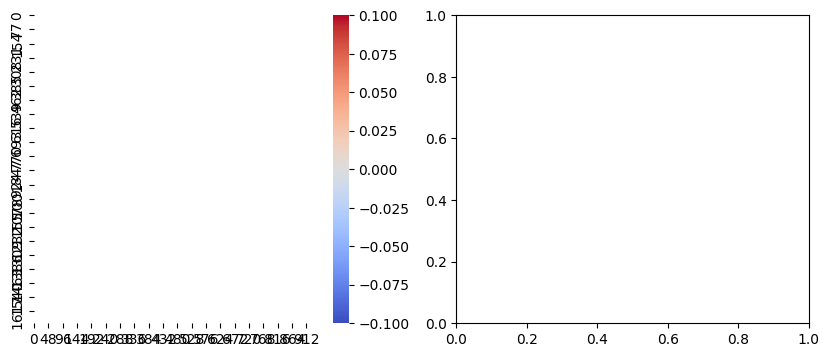

In [ ]:
# visualise training and test rating data
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(test, cmap="coolwarm",ax=ax1)
ax1.set_title("Test set u1.test")
ax1.set_xlabel('users')
ax1.set_ylabel('movies')
sns.heatmap(test1, cmap="coolwarm",ax=ax2)
ax2.set_title("Test set random 20%")
ax2.set_xlabel('users')
ax2.set_ylabel('movies')
plt.show()

In [ ]:
print("user 52's", data2[52].count(), 'ratings were split into', train[52].count(), 'training and', test[52].count(), 'testing')
print("user 53's", data2[53].count(), 'ratings were split into', train[53].count(), 'training and', test[53].count(), 'testing')
print("train set shape:", train.shape)
print("train set number of ratings:", np.count_nonzero(~np.isnan(train)))
print("test set shape:", test.shape)
print("test set number of ratings:", np.count_nonzero(~np.isnan(test)))

user 52's 28 ratings were split into 16 training and 12 testing
user 53's 65 ratings were split into 30 training and 35 testing
train set shape: (1682, 943)
train set number of ratings: 80000
test set shape: (1682, 943)
test set number of ratings: 20000


In [ ]:
# impute with 0
# train_imputed = train.fillna(0)

# impute with mean
# train_mean = np.nanmean(train.values)
# train_imputed = train.fillna(train_mean)

In [ ]:
mask = train.isna()

# alternatively fill all values with the overall average
train_mean = np.nanmean(train.values) #approx 3.5
# train_data = train.fillna(train_mean)

# Row and column average before imputation
column_mean = train.mean(axis=0)
row_mean = train.mean(axis=1)

# Row and column deviation from mean
row_deviation = train_mean - row_mean
column_deviation = train_mean - column_mean

# After splitting, some columns or rows might be empty, set those to 0
row_deviation = row_deviation.fillna(0)
column_deviation = column_deviation.fillna(0)

In [ ]:
# Fill null with dataframe average
train_imputation = train.fillna(train_mean)

'''
# For each column (user) of known ratings, remove deviation from average rating 
# of all users for all unknown values. Same for rows.
# remove user bias and item bias from imputed (previously null) values
for i, row in train.iterrows():
    for j in range(len(row)):
        if pd.isnull(row[j]):
            train_imputed.iloc[i, j] -= row_deviation[i]
            train_imputed.iloc[i, j] -= column_deviation[j]
'''

# subtract row deviation
train_imputation = train_imputation.sub(row_deviation, axis=0)

# subtract column deviation
train_imputation = train_imputation.sub(column_deviation, axis=1)

# Set values that are null to train_mean - row_deviation - column_deviation
train_imputed = train.where(~train.isna(), train_imputation)

train_imputed

userId,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,5.000000,4.000000,3.364600,4.721743,3.320644,4.000000,4.256619,3.964600,4.531267,4.577366,...,2.000000,3.000000,4.000000,3.739600,4.000000,4.629907,3.822544,5.000000,4.630423,3.775315
1,3.000000,3.452602,2.652602,4.009745,2.608646,3.234421,3.544621,3.252602,3.819269,3.865368,...,4.000000,3.575679,3.399081,3.027602,2.921121,3.917909,3.110546,3.698057,3.918425,5.000000
2,4.000000,3.271650,2.471650,3.828793,2.427694,3.053468,3.363669,3.071650,3.638317,3.684416,...,3.172799,3.394727,4.000000,2.846650,2.740169,3.736956,2.929594,3.517105,3.737473,2.882364
3,3.000000,3.797966,2.997966,4.355109,2.954010,3.579784,5.000000,3.597966,4.164632,4.210732,...,5.000000,3.921043,3.744445,3.372966,3.266484,4.263272,2.000000,4.043420,4.263789,3.408680
4,3.000000,3.575998,2.775998,4.133141,2.732042,3.357816,3.668017,3.375998,3.942664,3.988764,...,3.477147,3.699075,3.522477,3.150998,3.044516,4.041304,3.233942,3.821452,4.041821,3.186712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1.153131,1.271650,0.471650,1.828793,0.427694,1.053468,1.363669,1.071650,1.638317,1.684416,...,1.172799,1.394727,1.218129,0.846650,0.740169,1.736956,0.929594,1.517105,1.737473,0.882364
1678,3.153131,3.271650,2.471650,3.828793,2.427694,3.053468,3.363669,3.071650,3.638317,3.684416,...,3.172799,3.394727,3.218129,2.846650,2.740169,3.736956,2.929594,3.517105,3.737473,2.882364
1679,2.153131,2.271650,1.471650,2.828793,1.427694,2.053468,2.363669,2.071650,2.638317,2.684416,...,2.172799,2.394727,2.218129,1.846650,1.740169,2.736956,1.929594,2.517105,2.737473,1.882364
1680,3.153131,3.271650,2.471650,3.828793,2.427694,3.053468,3.363669,3.071650,3.638317,3.684416,...,3.172799,3.394727,3.218129,2.846650,2.740169,3.736956,2.929594,3.517105,3.737473,2.882364


## Baseline 

In [ ]:
predicted = np.nanmean(train)
print("Median rating:", "{:.3f}".format(predicted))

diffs = predicted - test
rmse = np.sqrt(np.nanmean(np.square(diffs)))
print("RMSE using median:", "{:.3f}".format(rmse))

Median rating: 3.528
RMSE using median: 1.154


In [ ]:
diffs = train_imputed - test
rmse = np.sqrt(np.nanmean(np.square(diffs)))
print("RMSE using median minus user item bias:", "{:.3f}".format(rmse))

RMSE using median minus user item bias: 0.980


## Eigendecomposition SVD 

In [ ]:
# inspired by https://github.com/amoghasubramanya/Movie-Recommender-using-SVD/blob/master/svd.py
# and https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

A = np.array(train_imputed)

import time
start_time = time.perf_counter()

# calculate U and sigma
AAT = np.dot(A, np.transpose(A)) #9724 x 9724
eigenvalueAAT, eigenvecAAT = np.linalg.eig(AAT)

# sorted indexes
sorted_eigen_indexes = eigenvalueAAT.argsort()[::-1]
# get real first k sorted eigen values
sigma = np.real(np.sqrt(eigenvalueAAT[sorted_eigen_indexes]))
# get real values sorted by eigenvectors
U = np.real(eigenvecAAT[:,sorted_eigen_indexes])

# calculate V
ATA = np.dot(np.transpose(A), A) #9724 x 9724
eigenvalueATA, eigenvecATA = np.linalg.eig(ATA)
# sort eigen values
sorted_eigen_indexesATA = eigenvalueATA.argsort()[::-1]
# get real values sorted by eigenvectors 
V = np.real(eigenvecATA[:,sorted_eigen_indexesATA])

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 4.446389777999684 seconds


In [ ]:
# inspired by https://github.com/amoghasubramanya/Movie-Recommender-using-SVD/blob/master/svd.py
# and https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

A = np.array(train_imputed)

import time
start_time = time.perf_counter()

# calculate U and sigma
AAT = np.dot(A, np.transpose(A)) #9724 x 9724
eigenvalueAAT, eigenvecAAT = np.linalg.eig(AAT)

# sorted indexes
sorted_eigen_indexes = eigenvalueAAT.argsort()[::-1]
# get real first k sorted eigen values
sigma = np.real(np.sqrt(eigenvalueAAT[sorted_eigen_indexes]))
# get real values sorted by eigenvectors
U = np.real(eigenvecAAT[:,sorted_eigen_indexes])

# calculate V
ATA = np.dot(np.transpose(A), A) #9724 x 9724
eigenvalueATA, eigenvecATA = np.linalg.eig(ATA)
# sort eigen values
sorted_eigen_indexesATA = eigenvalueATA.argsort()[::-1]
# get real values sorted by eigenvectors 
V = np.real(eigenvecATA[:,sorted_eigen_indexesATA])




k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 100, 250, 
          610, 943]
k_performance_manual = []
execution_times_manual = []


best_k = 0
rmse_at_best_k = 100

for k in k_list:
    U_k = U[:,0:k]
    sigma_k = np.diag(sigma[:k])
    VT_k = np.transpose(V[:,0:k])
    predicted = U_k @ sigma_k @ VT_k

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    #print("Execution time:", execution_time, "seconds")
    execution_times_manual.append(execution_time)

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))

    k_performance_manual.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

# Re-run FIX RMSE correct below
print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
#print(k_performance)

The lowest RMSE was 0.9574845517828339 and was achieved at k: 3


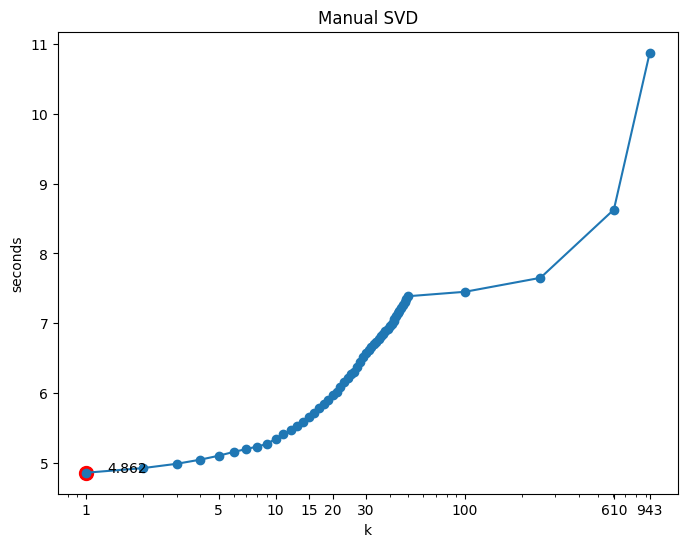

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_manual, marker='o')
plt.xlabel('k')
plt.ylabel('seconds')
plt.title('Manual SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(execution_times_manual)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], execution_times_manual[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, execution_times_manual[min_index], f'{execution_times_manual[min_index]:.3f}')

plt.show()

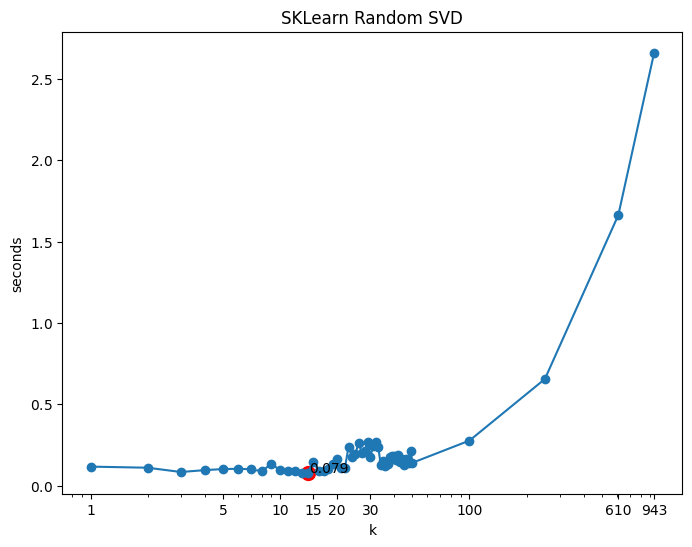

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_random, marker='o')
plt.xlabel('k')
plt.ylabel('seconds')
plt.title('SKLearn Random SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(execution_times_random)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], execution_times_random[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, execution_times_random[min_index], f'{execution_times_random[min_index]:.3f}')

plt.show()

## Facebook SVD

In [ ]:
!pip install fbpca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=ccd17ea035cb5dab4e1743c9151851165361e78747e0bab53446d5d3a3878692
  Stored in directory: /root/.cache/pip/wheels/f5/60/60/28df6c25f4d22b73d1a2b1c7e4842a5e2178e35e47b62e8e9a
Successfully built fbpca


In [ ]:
# https://fbpca.readthedocs.io/en/latest/#fbpca.pca

from fbpca import diffsnorm, pca
train_imputed = np.array(train_imputed)

U, sigma, V = pca(train_imputed, k=10, raw=True, n_iter=2, l=10)
predicted = U @ np.diag(sigma) @ V
VT = np.transpose(V)

print(U.shape)
print(np.diag(sigma).shape)
print(V.shape)

(1682, 10)
(10, 10)
(10, 943)


In [ ]:
# compute squared differences between non-NaN values
diffs = predicted - test
mask = ~(np.isnan(diffs) | np.isnan(test))
squared_diffs = np.square(diffs[mask])

# compute mean of squared differences
rmse = np.sqrt(np.nanmean(squared_diffs))
print(rmse)

0.956563854420859


In [ ]:
import time

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 100, 250, 
          610, 943]

n_iter_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

l = [2, 5, 10, 15, 20]
          
k_performance_f_random = []
execution_times_f_random = []

best_k = 0
best_iter = 0
best_l = 0

rmse_at_best_k = 100
time_at_best_rmse = 0

for oversample in l:
  for iter in n_iter_list:
    best_run = False

    temp_k_performance_f_random = []
    temp_execution_times_f_random = []

    for k_var in k_list:
        start_time = time.perf_counter()
        U, sigma, V = pca(train_imputed, k=k_var, raw=True, n_iter=iter, l=k_var+oversample)
        predicted = U @ np.diag(sigma) @ V

        end_time = time.perf_counter()
        execution_time = end_time - start_time
        temp_execution_times_f_random.append(execution_time)

        # compute squared differences between non-NaN values
        diffs = predicted - test
        mask = ~(np.isnan(diffs) | np.isnan(test))
        squared_diffs = np.square(diffs[mask])

        # compute mean of squared differences
        rmse = np.sqrt(np.nanmean(squared_diffs))
        temp_k_performance_f_random.append(rmse)

        
        if rmse_at_best_k > rmse:
            # If best run yet then at end of iteration set performance
            best_run = True
            best_k = k_var
            best_iter = iter
            best_l = oversample
            rmse_at_best_k = rmse
            time_at_best_rmse = execution_time

    if best_run:
        k_performance_f_random = temp_k_performance_f_random
        execution_times_f_random = temp_execution_times_f_random

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k, "iter", best_iter, "l", best_l)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.9457744756500057 and was achieved at k: 14 iter 10 l 2
Execution time at best k: 0.128071355999964 seconds


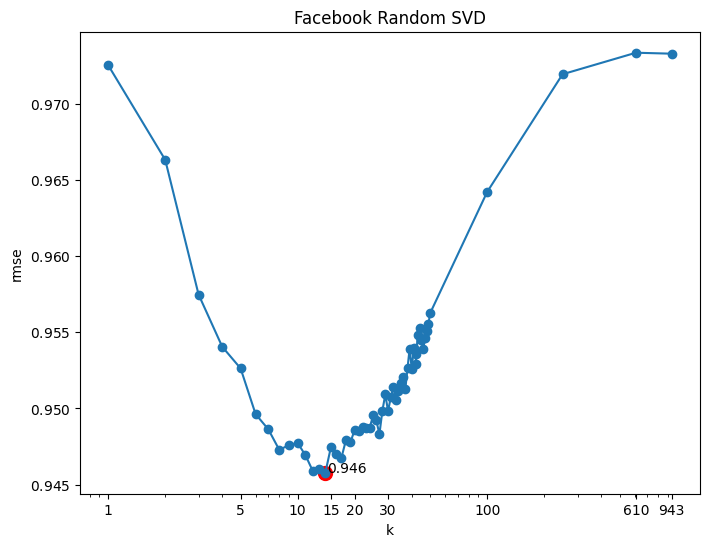

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, k_performance_f_random, marker='o')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('Facebook Random SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(k_performance_f_random)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], k_performance_f_random[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, k_performance_f_random[min_index], f'{k_performance_f_random[min_index]:.3f}')

plt.show()

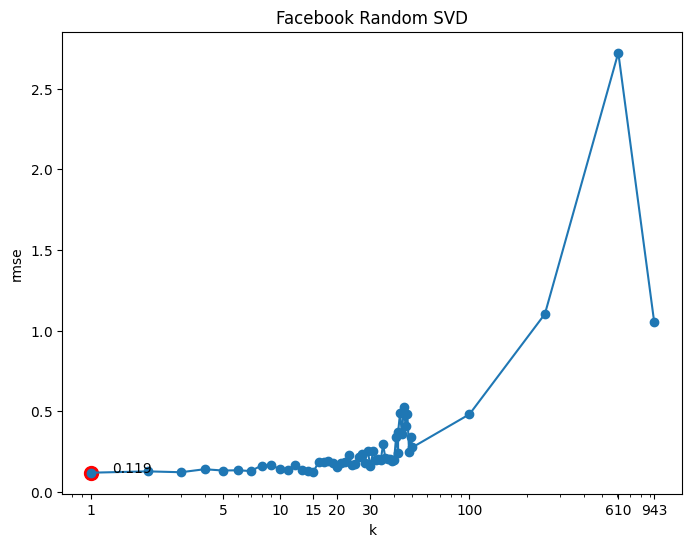

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_f_random, marker='o')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('Facebook Random SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(execution_times_f_random)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], execution_times_f_random[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, execution_times_f_random[min_index], f'{execution_times_f_random[min_index]:.3f}')

plt.show()

## Randomized SVD

In [ ]:
from sklearn.utils.extmath import randomized_svd
import time

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 100, 250, 
          610, 943]

k_performance_random = []
execution_times_random = []

best_k = 0
rmse_at_best_k = 100
time_at_best_rmse = 0

for k in k_list:
    start_time = time.perf_counter()
    U, Sigma, VT = randomized_svd(np.array(train_imputed), 
                                  n_components=k,
                                  n_iter=5,
                                  random_state=None)
    
    predicted = U @ np.diag(Sigma) @ VT

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times_random.append(execution_time)

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))
    k_performance_random.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.9404118792113512 and was achieved at k: 14
Execution time at best k: 0.12816226699999334 seconds


In [ ]:
import time

np_train_imputed = np.array(train_imputed)

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 100, 250, 
          610, 943]

n_iter_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

l = [2, 5, 10, 15, 20]
          
k_performance_random = []
execution_times_random = []

best_k = 0
best_iter = 0
best_l = 0

rmse_at_best_k = 100
time_at_best_rmse = 0

for oversample in l:
  for iter in n_iter_list:
    best_run = False

    temp_k_performance_f_random = []
    temp_execution_times_f_random = []

    for k_var in k_list:
        start_time = time.perf_counter()
        U, Sigma, VT = randomized_svd(np_train_imputed, 
                              n_components=k_var,
                              n_iter=iter,
                              n_oversamples=oversample,
                              random_state=None)

        predicted = U @ np.diag(Sigma) @ VT

        end_time = time.perf_counter()
        execution_time = end_time - start_time
        temp_execution_times_f_random.append(execution_time)

        # compute squared differences between non-NaN values
        diffs = predicted - test
        mask = ~(np.isnan(diffs) | np.isnan(test))
        squared_diffs = np.square(diffs[mask])

        # compute mean of squared differences
        rmse = np.sqrt(np.nanmean(squared_diffs))
        temp_k_performance_f_random.append(rmse)

        
        if rmse_at_best_k > rmse:
            # If best run yet then at end of iteration set performance
            best_run = True
            best_k = k_var
            best_iter = iter
            best_l = oversample
            rmse_at_best_k = rmse
            time_at_best_rmse = execution_time

    if best_run:
        k_performance_random = temp_k_performance_f_random
        execution_times_random = temp_execution_times_f_random

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k, "iter", best_iter, "l", best_l)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.9458362022487856 and was achieved at k: 13 iter 4 l 20
Execution time at best k: 0.07972913399999015 seconds


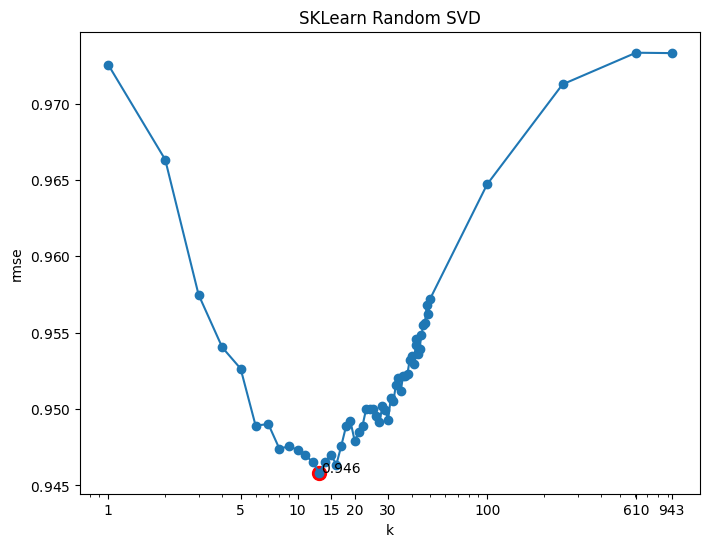

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, k_performance_random, marker='o')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('SKLearn Random SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(k_performance_random)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], k_performance_random[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, k_performance_random[min_index], f'{k_performance_random[min_index]:.3f}')

plt.show()

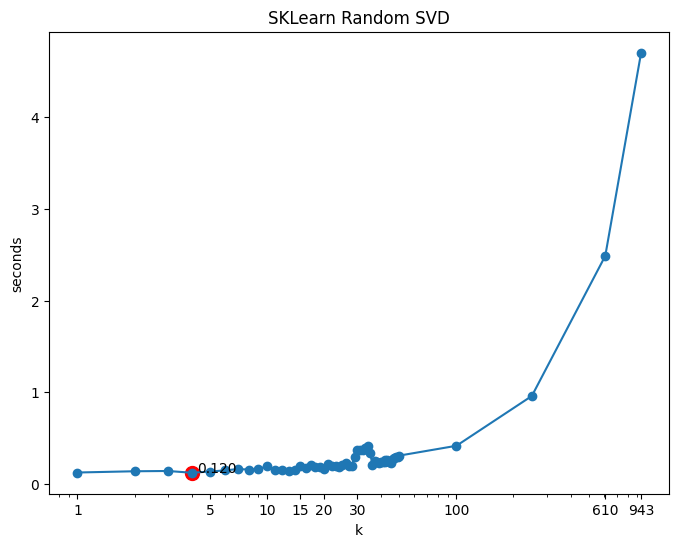

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_random, marker='o')
plt.xlabel('k')
plt.ylabel('seconds')
plt.title('SKLearn Random SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Index of the lowest value in performance
min_index = np.argmin(execution_times_random)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], execution_times_random[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, execution_times_random[min_index], f'{execution_times_random[min_index]:.3f}')

plt.show()

## Combined Plot

In [ ]:
k_sk = k_performance_random

In [ ]:
k_sk_2 = k_performance_random

In [ ]:
k_sk_3 = k_performance_random

<function matplotlib.pyplot.show(close=None, block=None)>

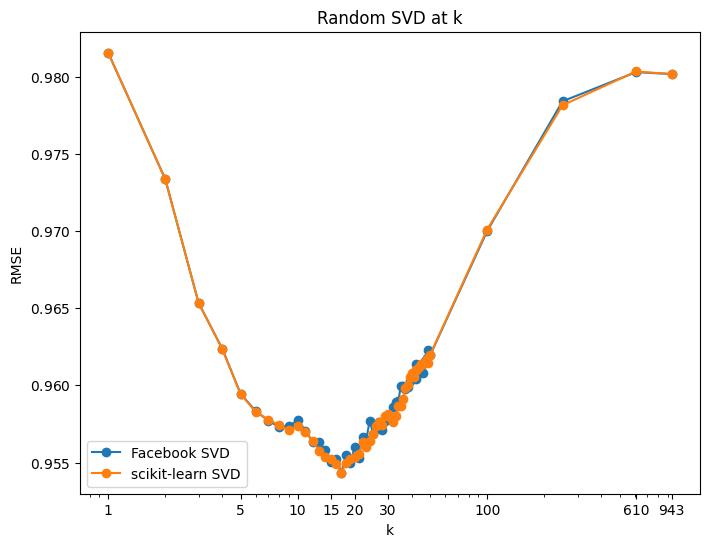

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

#plt.semilogx(k_list, k_sk, marker='o', label='Imputation with 0')
#plt.semilogx(k_list, k_sk_2, marker='o', label='Imputation with mean')
#plt.semilogx(k_list, k_sk_3, marker='o', label='Imputation with mean minus item/user deviation')

plt.semilogx(k_list, k_performance_f_random, marker='o', label='Facebook SVD')
plt.semilogx(k_list, k_performance_random, marker='o', label='scikit-learn SVD')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('Random SVD at k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

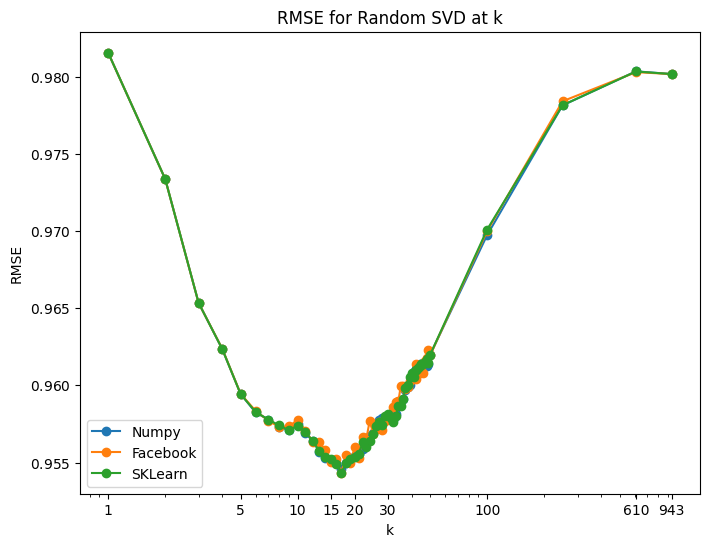

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, k_performance, marker='o', label='Numpy')
plt.semilogx(k_list, k_performance_f_random, marker='o', label='Facebook')
plt.semilogx(k_list, k_performance_random, marker='o', label='SKLearn')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('RMSE for Random SVD at k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

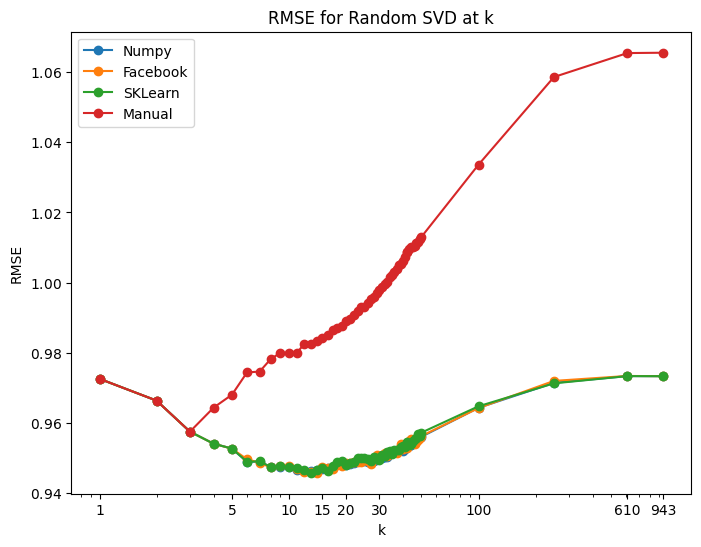

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, k_performance, marker='o', label='Numpy')
plt.semilogx(k_list, k_performance_f_random, marker='o', label='Facebook')
plt.semilogx(k_list, k_performance_random, marker='o', label='SKLearn')
plt.semilogx(k_list, k_performance_manual, marker='o', label='Manual')


# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('RMSE for Random SVD at k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

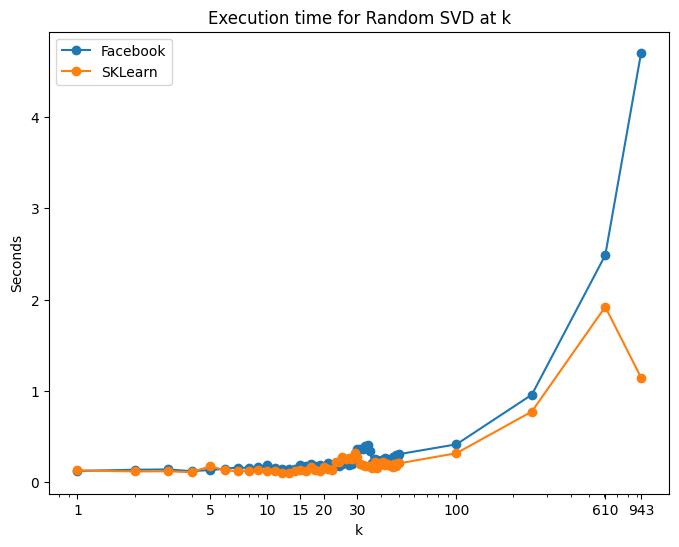

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_random, marker='o', label='Facebook')
plt.semilogx(k_list, execution_times_f_random, marker='o', label='SKLearn')


# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('Execution time for Random SVD at k')
plt.xlabel('k')
plt.ylabel('Seconds')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

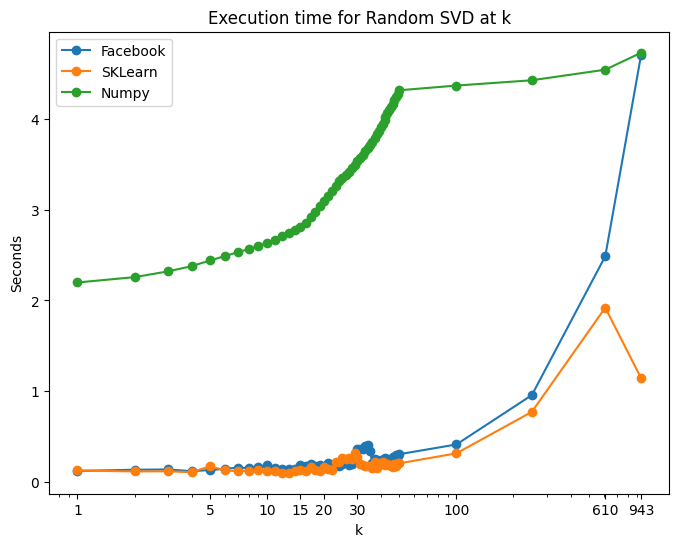

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_random, marker='o', label='Facebook')
plt.semilogx(k_list, execution_times_f_random, marker='o', label='SKLearn')
plt.semilogx(k_list, execution_times_numpy, marker='o', label='Numpy')
plt.semilogx(k_list, execution_times_manual, marker='o', label='Manual')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('Execution time for Random SVD at k')
plt.xlabel('k')
plt.ylabel('Seconds')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

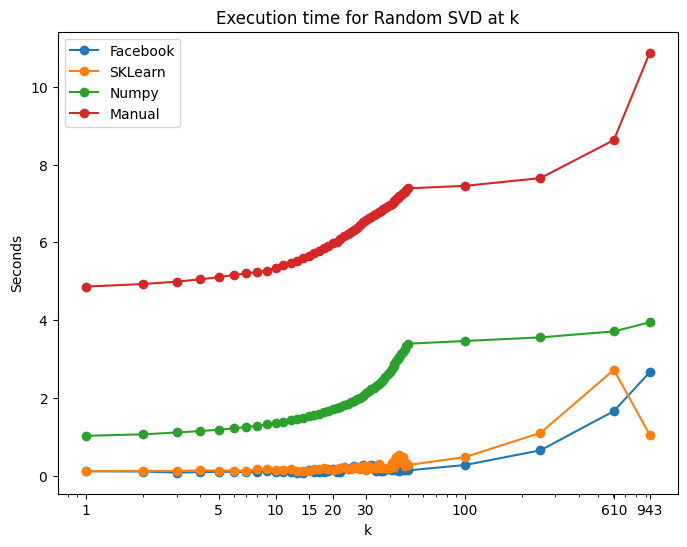

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, execution_times_random, marker='o', label='Facebook')
plt.semilogx(k_list, execution_times_f_random, marker='o', label='SKLearn')
plt.semilogx(k_list, execution_times_numpy, marker='o', label='Numpy')
plt.semilogx(k_list, execution_times_manual, marker='o', label='Manual')

# Set x-axis tick locations and labels
x_ticks = [1, 5, 10, 15, 20, 30, 100, 610, 943]
x_tick_labels = ['1', '5', '10', '15', '20', '30', '100', '610', '943']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.title('Execution time for Random SVD at k')
plt.xlabel('k')
plt.ylabel('Seconds')
plt.legend()
plt.show

## Numpy

In [ ]:
# Compute the explained variance ratio for each factor
explained_var_ratio = (sigma ** 2) / np.sum(sigma ** 2)

print(explained_var_ratio[0] / sum(explained_var_ratio) * 100, '%')

# Print the explained variance ratio for each factor
print('Explained variance ratio:', explained_var_ratio[:5])

99.91152710070433 %
Explained variance ratio: [9.99115271e-01 2.61257807e-05 1.71713547e-05 1.66040170e-05
 1.47913954e-05]


In [ ]:
# Numpy SVD

from sklearn.utils.extmath import randomized_svd
import time

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 100, 250, 
          610, 943]
k_performance = []
execution_times_numpy = []

best_k = 0
rmse_at_best_k = 100
time_at_best_rmse = 0

start_time = time.perf_counter()
U, sigma, VT = np.linalg.svd(np.array(train_imputed),full_matrices=False)

for k in k_list:
    predicted = U[:, :k] @ np.diag(sigma[:k]) @ VT[:k, :]

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times_numpy.append(execution_time)
    
    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))
    k_performance.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.946249889861708 and was achieved at k: 13
Execution time at best k: 1.4605762060000416 seconds


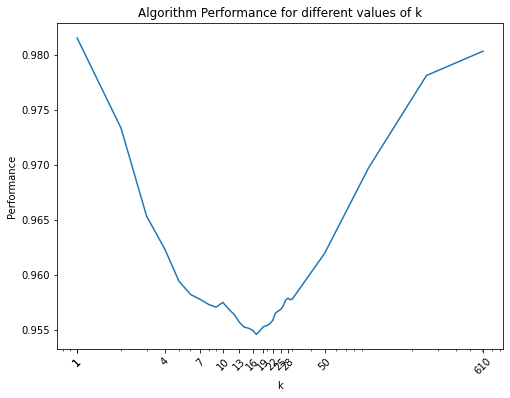

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # adjust the size of the figure

plt.plot(k_list, k_performance)
plt.xscale('log')
plt.xticks([1]+k_list[::3], [1]+k_list[::3], rotation=45) # rotate the tick labels
plt.xlabel('k')
plt.ylabel('Performance')
plt.title('Algorithm Performance for different values of k')
plt.show()

In [ ]:
from sklearn.utils.extmath import randomized_svd
import time

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 50, 100, 250, 610]
k_performance = []

best_k = 0
rmse_at_best_k = 100
time_at_best_rmse = 0

for k in k_list:
    start_time = time.perf_counter()
    U, Sigma, VT = randomized_svd(np.array(train_imputed), 
                                  n_components=k,
                                  n_iter=5,
                                  random_state=None)
    
    predicted = U @ np.diag(Sigma) @ VT

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))
    
    k_performance.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.8983040096211258 and was achieved at k: 19
Execution time at best k: 0.5756495990008261 seconds


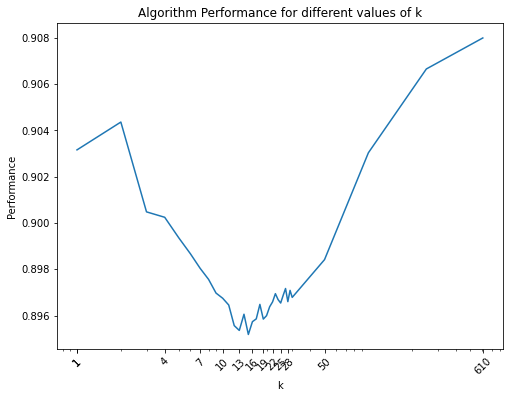

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # adjust the size of the figure

plt.plot(k_list, k_performance)
plt.xscale('log')
plt.xticks([1]+k_list[::3], [1]+k_list[::3], rotation=45) # rotate the tick labels
plt.xlabel('k')
plt.ylabel('Performance')
plt.title('Algorithm Performance for different values of k')
plt.show()

## Deep Learning Simple

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            nn.Linear(embedding_size, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        # return ratings between 1 and 5
        return self.out(linear_input) * 4 + 1

mf = MatrixFactorization(609,9723,100)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(609, 100)
  (movie_embed): Embedding(9723, 100)
  (linear_layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 1093601


In [ ]:
da = df.copy()
da['userId'] = da['userId'].replace(userId_to_i)
da['movieId'] = da['movieId'].replace(movieId_to_i)

#df_train['userId'] = df['userId'].replace(userId_to_i)
#df_train['movieId'] = df['movieId'].replace(movieId_to_i)

#df_test['userId'] = df['userId'].replace(userId_to_i)
#df_test['movieId'] = df['movieId'].replace(movieId_to_i)

In [ ]:
'''
df_train, df_valid = model_selection.train_test_split(
    da, test_size=0.1, random_state=42
)
'''


def get_20pct_ratings_by_user(df, user_colname="userId", timestamp_colname="timestamp"):
    # sort by user and timestamp
    sorted_df = df.sort_values([user_colname, timestamp_colname])

    # group by user and calculate 10% cut-off index for each group
    groups = (
        sorted_df.groupby(user_colname, as_index=False)
        .apply(lambda x: x.iloc[-int(0.2*len(x)):])
    )

    # sort by user and timestamp
    sorted_df = groups.sort_values([user_colname, timestamp_colname])

    return sorted_df

test = get_20pct_ratings_by_user(da).reset_index(drop=True)

merged = da.merge(test, how='left', indicator=True)
train = merged.loc[merged['_merge'] == 'left_only']
train = train.drop(columns=['_merge'])


print(len(test[test['userId'] == 0]))
print(len(train[train['userId'] == 0]))

54
218


In [ ]:
train_dataset = MovieLensDataset(train)
valid_dataset = MovieLensDataset(test)

#train_dataset = MovieLensDataset(df_train)
#valid_dataset = MovieLensDataset(df_test)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=len(train_dataset),
                          shuffle=True)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=len(valid_dataset),
                          shuffle=True) 

In [ ]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 100)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [ ]:
model(torch.tensor([942]), torch.tensor([1681])).squeeze()

tensor(3.0632, grad_fn=<SqueezeBackward0>)

In [ ]:
import torch.optim as optim
import time

trainingEpoch_loss = []
validationEpoch_loss = []
trainingEpoch_RMSE = []
validationEpoch_RMSE = []
cumulative_train_time = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss.append(train_loss)
        validationEpoch_loss.append(validation_loss)
        trainingEpoch_RMSE.append(train_rmse)
        validationEpoch_RMSE.append(val_rmse)
        if cumulative_train_time == []:
            cumulative_train_time.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time.append(cumulative_train_time[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
        print(cumulative_train_time[-1])

    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=150, lr=0.002, weight_decay=0.0001)

Epoch 1/150, Train Loss: 1.6593, Validation Loss: 1.5368, Train RMSE: 1.2666, Val RMSE: 1.2397, Train Time: 4.652s
4.652190109999992
Epoch 2/150, Train Loss: 1.6044, Validation Loss: 1.5057, Train RMSE: 1.2454, Val RMSE: 1.2271, Train Time: 4.369s
9.021021352999924
Epoch 3/150, Train Loss: 1.5512, Validation Loss: 1.4741, Train RMSE: 1.2224, Val RMSE: 1.2140, Train Time: 4.111s
13.131720796999844
Epoch 4/150, Train Loss: 1.4946, Validation Loss: 1.4430, Train RMSE: 1.1979, Val RMSE: 1.2012, Train Time: 4.682s
17.81394869299993
Epoch 5/150, Train Loss: 1.4355, Validation Loss: 1.4129, Train RMSE: 1.1720, Val RMSE: 1.1887, Train Time: 4.141s
21.95538562699994
Epoch 6/150, Train Loss: 1.3737, Validation Loss: 1.3843, Train RMSE: 1.1435, Val RMSE: 1.1764, Train Time: 4.200s
26.155653954999934
Epoch 7/150, Train Loss: 1.3076, Validation Loss: 1.3604, Train RMSE: 1.1140, Val RMSE: 1.1664, Train Time: 4.728s
30.884077473999923
Epoch 8/150, Train Loss: 1.2412, Validation Loss: 1.3495, Train RM

KeyboardInterrupt: ignored

In [ ]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 100)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [ ]:
import torch.optim as optim
import time

trainingEpoch_loss_100 = []
validationEpoch_loss_100 = []
trainingEpoch_RMSE_100 = []
validationEpoch_RMSE_100 = []
cumulative_train_time_100 = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss_100.append(train_loss)
        validationEpoch_loss_100.append(validation_loss)
        trainingEpoch_RMSE_100.append(train_rmse)
        validationEpoch_RMSE_100.append(val_rmse)
        if cumulative_train_time_100 == []:
            cumulative_train_time_100.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time_100.append(cumulative_train_time_100[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
    
    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=100, lr=0.002, weight_decay=0.0001)

<function matplotlib.pyplot.show(close=None, block=None)>

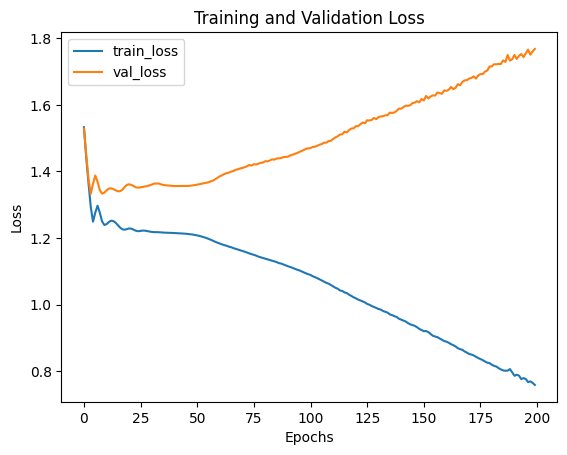

In [ ]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.plot(trainingEpoch_loss_100,label='val_loss')
plt.plot(validationEpoch_loss_100,label='val_loss')
plt.plot(validationEpoch_loss_large_200,label='val_loss')
plt.plot(trainingEpoch_loss_large_200,label='val_loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

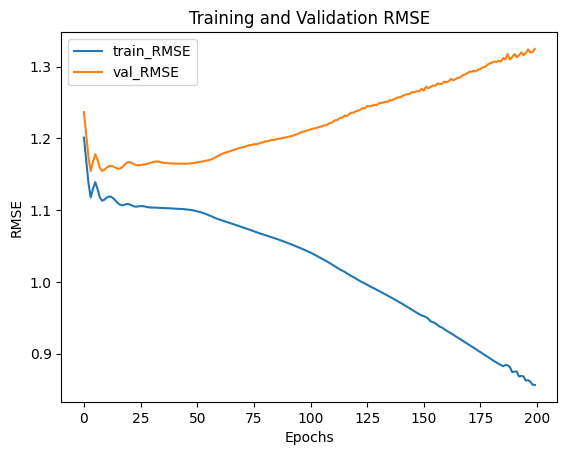

In [ ]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_RMSE, label='train_RMSE')
plt.plot(validationEpoch_RMSE,label='val_RMSE')
plt.plot(trainingEpoch_RMSE_100, label='train_RMSE')
plt.plot(validationEpoch_RMSE_100,label='val_RMSE')
plt.plot(trainingEpoch_RMSE_large_200, label='train_RMSE')
plt.plot(validationEpoch_RMSE_large_200, label='train_RMSE')


plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show

## MF

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)

        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_bias = nn.Embedding(n_movies, 1)

        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        dot_product = (self.user_embedding(users) * self.item_embedding(movies)).sum(1)

        output = dot_product + self.user_bias(users) + self.movie_bias(movies)

        return torch.sigmoid(output) * 4 + 1

mf = MatrixFactorization(609,9723,100)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(609, 100)
  (movie_embed): Embedding(9723, 100)
  (user_bias): Embedding(609, 1)
  (movie_bias): Embedding(9723, 1)
)
Number of paramters: 1043532


## Deep Learning 1

In [12]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [13]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(embedding_size // 2, embedding_size // 4),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(embedding_size // 4, embedding_size // 8),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(embedding_size // 8, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        # return ratings between 1 and 5
        return self.out(linear_input) * 4 + 1

In [ ]:
#mf = MatrixFactorization(609,9723,100)
mf = MatrixFactorization(943,1682,128)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(943, 128)
  (movie_embed): Embedding(1682, 128)
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 379777


In [14]:
da = df.copy()
da['userId'] = da['userId'].replace(userId_to_i)
da['movieId'] = da['movieId'].replace(movieId_to_i)

#df_train['userId'] = df['userId'].replace(userId_to_i)
#df_train['movieId'] = df['movieId'].replace(movieId_to_i)

#df_test['userId'] = df['userId'].replace(userId_to_i)
#df_test['movieId'] = df['movieId'].replace(movieId_to_i)

In [15]:
train, test = model_selection.train_test_split(
    da, test_size=0.1, random_state=42
)


'''
def get_20pct_ratings_by_user(df, user_colname="userId", timestamp_colname="timestamp"):
    # sort by user and timestamp
    sorted_df = df.sort_values([user_colname, timestamp_colname])

    # group by user and calculate 10% cut-off index for each group
    groups = (
        sorted_df.groupby(user_colname, as_index=False)
        .apply(lambda x: x.iloc[-int(0.2*len(x)):])
    )

    # sort by user and timestamp
    sorted_df = groups.sort_values([user_colname, timestamp_colname])

    return sorted_df

test = get_20pct_ratings_by_user(da).reset_index(drop=True)

merged = da.merge(test, how='left', indicator=True)
train = merged.loc[merged['_merge'] == 'left_only']
train = train.drop(columns=['_merge'])


print(len(test[test['userId'] == 0]))
print(len(train[train['userId'] == 0]))
'''

'\ndef get_20pct_ratings_by_user(df, user_colname="userId", timestamp_colname="timestamp"):\n    # sort by user and timestamp\n    sorted_df = df.sort_values([user_colname, timestamp_colname])\n\n    # group by user and calculate 10% cut-off index for each group\n    groups = (\n        sorted_df.groupby(user_colname, as_index=False)\n        .apply(lambda x: x.iloc[-int(0.2*len(x)):])\n    )\n\n    # sort by user and timestamp\n    sorted_df = groups.sort_values([user_colname, timestamp_colname])\n\n    return sorted_df\n\ntest = get_20pct_ratings_by_user(da).reset_index(drop=True)\n\nmerged = da.merge(test, how=\'left\', indicator=True)\ntrain = merged.loc[merged[\'_merge\'] == \'left_only\']\ntrain = train.drop(columns=[\'_merge\'])\n\n\nprint(len(test[test[\'userId\'] == 0]))\nprint(len(train[train[\'userId\'] == 0]))\n'

In [16]:
train_dataset = MovieLensDataset(train)
valid_dataset = MovieLensDataset(test)

#train_dataset = MovieLensDataset(df_train)
#valid_dataset = MovieLensDataset(df_test)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4096)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4096) 

In [ ]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 128)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [ ]:
model(torch.tensor([942]), torch.tensor([1681])).squeeze()

tensor(3.1321, grad_fn=<SqueezeBackward0>)

In [ ]:
import torch.optim as optim
import time

trainingEpoch_loss = []
validationEpoch_loss = []
trainingEpoch_RMSE = []
validationEpoch_RMSE = []
cumulative_train_time = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss.append(train_loss)
        validationEpoch_loss.append(validation_loss)
        trainingEpoch_RMSE.append(train_rmse)
        validationEpoch_RMSE.append(val_rmse)
        if cumulative_train_time == []:
            cumulative_train_time.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time.append(cumulative_train_time[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
        print(cumulative_train_time[-1])

    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=50, lr=0.001, weight_decay=0.0001)

Epoch 1/50, Train Loss: 1.0085, Validation Loss: 0.8832, Train RMSE: 0.9063, Val RMSE: 0.9180, Train Time: 38.448s
38.448053612999985
Epoch 2/50, Train Loss: 0.8585, Validation Loss: 0.8549, Train RMSE: 0.8897, Val RMSE: 0.9055, Train Time: 38.488s
76.93584463099998
Epoch 3/50, Train Loss: 0.8357, Validation Loss: 0.8411, Train RMSE: 0.8793, Val RMSE: 0.8994, Train Time: 38.455s
115.39073372399997
Epoch 4/50, Train Loss: 0.8160, Validation Loss: 0.8271, Train RMSE: 0.8684, Val RMSE: 0.8931, Train Time: 39.658s
155.04862046199997
Epoch 5/50, Train Loss: 0.7987, Validation Loss: 0.8266, Train RMSE: 0.8634, Val RMSE: 0.8914, Train Time: 38.617s
193.665976903
Epoch 6/50, Train Loss: 0.7888, Validation Loss: 0.8222, Train RMSE: 0.8602, Val RMSE: 0.8903, Train Time: 37.638s
231.30412069099998
Epoch 7/50, Train Loss: 0.7809, Validation Loss: 0.8245, Train RMSE: 0.8584, Val RMSE: 0.8913, Train Time: 47.404s
278.70806650699996
Epoch 8/50, Train Loss: 0.7747, Validation Loss: 0.8247, Train RMSE:

In [ ]:
print(trainingEpoch_RMSE)

[0.9063488098349448, 0.8896793602954517, 0.8793396785301674, 0.8684453567810623, 0.8634261331033521, 0.8602469608989445, 0.8584449794484555, 0.8550814581885097, 0.851901555608046, 0.8484715190485499, 0.8464721851242063, 0.8434537794291009, 0.8411310373767371, 0.838248213499872, 0.834558855638669, 0.8307236847542036, 0.8276041594960198, 0.822826889078269, 0.8198846190473804, 0.8146936663921354, 0.8105965859383183, 0.8065608015367243, 0.8023524653977255, 0.7993208614056878, 0.7956864528980151, 0.7911409466833856, 0.7871533642768486, 0.7829389454822453, 0.7801289358299204, 0.7765266628313566, 0.7736092899968519, 0.7698678231587464, 0.7677010405810614, 0.7645354031036231, 0.7615080462558538, 0.7576601332299213, 0.7547503502648437, 0.7519401962284493, 0.7497257353331298, 0.7459127765873701, 0.74454132567925, 0.7419477576810882, 0.7393698463772796, 0.7367212928596301, 0.7354388718420068, 0.7325974702451051, 0.7300985079137249, 0.7293851342365992, 0.726692458595682, 0.7247429224666794]


In [27]:
one = [0.9180,0.9055,0.8994,0.8931,0.8914,0.8903,0.8913,0.8911,0.8901,0.8897,0.8910,0.8915,0.8922,0.8928,0.8924,0.8914,0.8915,0.8917,0.8914,0.8914,0.8891,0.8890,0.8878,0.8871,0.8864,0.8870,0.8844,0.8861,0.8847,0.8875,0.8883,0.8870,0.8882,0.8892,0.8877,0.8884,0.8887,0.8895,0.8892,0.8899,0.8900,0.8895,0.8924,0.8920,0.8929,0.8921,0.8923,0.8938,0.8924,0.8927]
print(min(one))

0.8844


## Deep Learning 2

In [10]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [11]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(embedding_size // 2, embedding_size // 4),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(embedding_size // 4, embedding_size // 8),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(embedding_size // 8, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        # return ratings between 1 and 5
        return self.out(linear_input) * 4 + 1

In [12]:
#mf = MatrixFactorization(609,9723,100)
mf = MatrixFactorization(943,1682,64)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(943, 64)
  (movie_embed): Embedding(1682, 64)
  (linear_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=16, out_features=8, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=8, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 179009


In [17]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=2048)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2048) 

In [18]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 64)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [19]:
model(torch.tensor([942]), torch.tensor([1681])).squeeze()

tensor(2.8824, grad_fn=<SqueezeBackward0>)

In [20]:
import torch.optim as optim
import time

trainingEpoch_loss_2 = []
validationEpoch_loss_2 = []
trainingEpoch_RMSE_2 = []
validationEpoch_RMSE_2 = []
cumulative_train_time_2 = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss_2.append(train_loss)
        validationEpoch_loss_2.append(validation_loss)
        trainingEpoch_RMSE_2.append(train_rmse)
        validationEpoch_RMSE_2.append(val_rmse)
        if cumulative_train_time_2 == []:
            cumulative_train_time_2.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time_2.append(cumulative_train_time_2[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
        print(cumulative_train_time_2[-1])

    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=50, lr=0.001, weight_decay=0.0001)

Epoch 1/50, Train Loss: 0.9952, Validation Loss: 0.8618, Train RMSE: 0.8994, Val RMSE: 0.9129, Train Time: 31.825s
31.825242239999994
Epoch 2/50, Train Loss: 0.8432, Validation Loss: 0.8412, Train RMSE: 0.8879, Val RMSE: 0.9045, Train Time: 28.685s
60.509923226999945
Epoch 3/50, Train Loss: 0.8230, Validation Loss: 0.8299, Train RMSE: 0.8795, Val RMSE: 0.8995, Train Time: 29.610s
90.12004805499996
Epoch 4/50, Train Loss: 0.8056, Validation Loss: 0.8163, Train RMSE: 0.8671, Val RMSE: 0.8920, Train Time: 54.713s
144.83308000199997
Epoch 5/50, Train Loss: 0.7881, Validation Loss: 0.8145, Train RMSE: 0.8617, Val RMSE: 0.8906, Train Time: 87.520s
232.35299150299994
Epoch 6/50, Train Loss: 0.7764, Validation Loss: 0.8114, Train RMSE: 0.8585, Val RMSE: 0.8895, Train Time: 92.224s
324.577136565
Epoch 7/50, Train Loss: 0.7691, Validation Loss: 0.8114, Train RMSE: 0.8559, Val RMSE: 0.8897, Train Time: 112.687s
437.2641426089999
Epoch 8/50, Train Loss: 0.7630, Validation Loss: 0.8140, Train RMSE:

In [45]:
print(validationEpoch_RMSE_2)
print(min(validationEpoch_RMSE_2))

[0.9129382234883846, 0.904510300006203, 0.8994673588874735, 0.8919670798257389, 0.8906261210373594, 0.889505935904493, 0.8896670700604001, 0.8907969559625731, 0.8915206992224749, 0.8912836419372477, 0.8926472479217062, 0.8923470121293555, 0.8935237631324429, 0.8942042019866856, 0.8944933977677532, 0.8930865119763071, 0.8933318733741511, 0.8938398857536395, 0.8939474665746988, 0.8939534338014443, 0.8940750618015058, 0.892138403007777, 0.8928759472452172, 0.8929171252418704, 0.8932717241159054, 0.8933907753628783, 0.8916509509291451, 0.8919772184947028, 0.8933214853648903, 0.8941131894289506, 0.8946939776968813, 0.8952534769075846, 0.8953819916579484, 0.8956238199769156, 0.8956711600207619, 0.8984551192665233, 0.897167007729343, 0.9015277833337203, 0.8999471469566714, 0.8987543346977535, 0.9005483658601582, 0.9015793752286299, 0.9005044660829834, 0.9026267341108232, 0.9018314151147556, 0.9027735978539546, 0.9047784883466413, 0.9032562065151588, 0.9038143063318045, 0.9054538292191321]
0.8

In [28]:
#two = validationEpoch_RMSE_2
two = [0.9129382234883846, 0.904510300006203, 0.8994673588874735, 0.8919670798257389, 0.8906261210373594, 0.889505935904493, 0.8896670700604001, 0.8907969559625731, 0.8915206992224749, 0.8912836419372477, 0.8926472479217062, 0.8923470121293555, 0.8935237631324429, 0.8942042019866856, 0.8944933977677532, 0.8930865119763071, 0.8933318733741511, 0.8938398857536395, 0.8939474665746988, 0.8939534338014443, 0.8940750618015058, 0.892138403007777, 0.8928759472452172, 0.8929171252418704, 0.8932717241159054, 0.8933907753628783, 0.8916509509291451, 0.8919772184947028, 0.8933214853648903, 0.8941131894289506, 0.8946939776968813, 0.8952534769075846, 0.8953819916579484, 0.8956238199769156, 0.8956711600207619, 0.8984551192665233, 0.897167007729343, 0.9015277833337203, 0.8999471469566714, 0.8987543346977535, 0.9005483658601582, 0.9015793752286299, 0.9005044660829834, 0.9026267341108232, 0.9018314151147556, 0.9027735978539546, 0.9047784883466413, 0.9032562065151588, 0.9038143063318045, 0.9054538292191321]


## Deep Learning 3

In [23]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [24]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size // 2, embedding_size // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size // 4, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        # return ratings between 1 and 5
        return self.out(linear_input) * 4 + 1

In [25]:
#mf = MatrixFactorization(609,9723,100)
mf = MatrixFactorization(943,1682,64)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(943, 64)
  (movie_embed): Embedding(1682, 64)
  (linear_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 178881


In [26]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=2048)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2048) 

In [27]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 64)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [28]:
model(torch.tensor([942]), torch.tensor([1681])).squeeze()

tensor(3.0227, grad_fn=<SqueezeBackward0>)

In [29]:
import torch.optim as optim
import time

trainingEpoch_loss_3 = []
validationEpoch_loss_3 = []
trainingEpoch_RMSE_3 = []
validationEpoch_RMSE_3 = []
cumulative_train_time_3 = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss_3.append(train_loss)
        validationEpoch_loss_3.append(validation_loss)
        trainingEpoch_RMSE_3.append(train_rmse)
        validationEpoch_RMSE_3.append(val_rmse)
        if cumulative_train_time_3 == []:
            cumulative_train_time_3.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time_3.append(cumulative_train_time_3[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
        print(cumulative_train_time_3[-1])

    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=50, lr=0.002, weight_decay=0.0001)

Epoch 1/50, Train Loss: 0.9073, Validation Loss: 0.8429, Train RMSE: 0.8978, Val RMSE: 0.9125, Train Time: 29.380s
29.37951619500018
Epoch 2/50, Train Loss: 0.8251, Validation Loss: 0.8261, Train RMSE: 0.8844, Val RMSE: 0.9034, Train Time: 37.217s
66.59697601700009
Epoch 3/50, Train Loss: 0.8024, Validation Loss: 0.8114, Train RMSE: 0.8712, Val RMSE: 0.8945, Train Time: 28.723s
95.31975180900008
Epoch 4/50, Train Loss: 0.7872, Validation Loss: 0.8056, Train RMSE: 0.8653, Val RMSE: 0.8917, Train Time: 56.920s
152.23993826000014
Epoch 5/50, Train Loss: 0.7776, Validation Loss: 0.8064, Train RMSE: 0.8640, Val RMSE: 0.8927, Train Time: 79.692s
231.9319314940003
Epoch 6/50, Train Loss: 0.7699, Validation Loss: 0.8053, Train RMSE: 0.8603, Val RMSE: 0.8916, Train Time: 95.188s
327.1197694810003
Epoch 7/50, Train Loss: 0.7629, Validation Loss: 0.8055, Train RMSE: 0.8577, Val RMSE: 0.8916, Train Time: 89.110s
416.22968721700045
Epoch 8/50, Train Loss: 0.7568, Validation Loss: 0.8109, Train RMSE

In [30]:
print(validationEpoch_RMSE_3)

[0.9124966039164942, 0.9034304591677733, 0.894461258103926, 0.8916758609512827, 0.8926532930571225, 0.8915558555164488, 0.8915994567127221, 0.8942867966410964, 0.8918457088336462, 0.8933772596005695, 0.8933170015398225, 0.8932013058383633, 0.8920459955257768, 0.8896583145648702, 0.8919919001880114, 0.89019114857525, 0.8911450515641048, 0.8904331400204474, 0.8880932731110823, 0.8866877825070727, 0.8879231101493399, 0.8870617519711337, 0.8867292545876394, 0.8886693645630167, 0.8842803764759282, 0.8862867723403453, 0.885071711180916, 0.8865646329175967, 0.8838970068775778, 0.886870939014242, 0.8865059944828367, 0.8883581630825667, 0.8860779863124236, 0.887892349918982, 0.8870071689518986, 0.8882609761965113, 0.8895706920733304, 0.8869537673646285, 0.8891144964594873, 0.8907707169149377, 0.8910159168397234, 0.8891885675548111, 0.8894903122936265, 0.8901188129480414, 0.8901296916714417, 0.8890906919523887, 0.8892233017562924, 0.889050980132727, 0.8919493238369658, 0.8936526479707935]


In [29]:
#three = validationEpoch_RMSE_3
three = [0.9124966039164942, 0.9034304591677733, 0.894461258103926, 0.8916758609512827, 0.8926532930571225, 0.8915558555164488, 0.8915994567127221, 0.8942867966410964, 0.8918457088336462, 0.8933772596005695, 0.8933170015398225, 0.8932013058383633, 0.8920459955257768, 0.8896583145648702, 0.8919919001880114, 0.89019114857525, 0.8911450515641048, 0.8904331400204474, 0.8880932731110823, 0.8866877825070727, 0.8879231101493399, 0.8870617519711337, 0.8867292545876394, 0.8886693645630167, 0.8842803764759282, 0.8862867723403453, 0.885071711180916, 0.8865646329175967, 0.8838970068775778, 0.886870939014242, 0.8865059944828367, 0.8883581630825667, 0.8860779863124236, 0.887892349918982, 0.8870071689518986, 0.8882609761965113, 0.8895706920733304, 0.8869537673646285, 0.8891144964594873, 0.8907707169149377, 0.8910159168397234, 0.8891885675548111, 0.8894903122936265, 0.8901188129480414, 0.8901296916714417, 0.8890906919523887, 0.8892233017562924, 0.889050980132727, 0.8919493238369658, 0.8936526479707935]
print(min(three))

0.8838970068775778


## Deep Learning 4

In [17]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [18]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(embedding_size // 2, embedding_size // 4),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(embedding_size // 4, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        # return ratings between 1 and 5
        return self.out(linear_input) * 4 + 1

In [19]:
#mf = MatrixFactorization(609,9723,100)
mf = MatrixFactorization(943,1682,32)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(943, 32)
  (movie_embed): Embedding(1682, 32)
  (linear_layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 86753


In [20]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=2048)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2048) 

In [21]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 32)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [22]:
model(torch.tensor([942]), torch.tensor([1681])).squeeze()

tensor(3.2118, grad_fn=<SqueezeBackward0>)

In [23]:
import torch.optim as optim
import time

trainingEpoch_loss_4 = []
validationEpoch_loss_4 = []
trainingEpoch_RMSE_4 = []
validationEpoch_RMSE_4 = []
cumulative_train_time_4 = []

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)

        train_rmse = evaluate_model(model, train_loader)
        val_rmse = evaluate_model(model, val_loader)

        trainingEpoch_loss_4.append(train_loss)
        validationEpoch_loss_4.append(validation_loss)
        trainingEpoch_RMSE_4.append(train_rmse)
        validationEpoch_RMSE_4.append(val_rmse)
        if cumulative_train_time_4 == []:
            cumulative_train_time_4.append(time.perf_counter() - epoch_start_time)
        else:
            cumulative_train_time_4.append(cumulative_train_time_4[-1] + time.perf_counter() - epoch_start_time)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
        print(cumulative_train_time_4[-1])

    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=50, lr=0.002, weight_decay=0.0001)

Epoch 1/50, Train Loss: 0.9073, Validation Loss: 0.8248, Train RMSE: 0.8927, Val RMSE: 0.9082, Train Time: 25.483s
25.483471043999998
Epoch 2/50, Train Loss: 0.8072, Validation Loss: 0.8106, Train RMSE: 0.8814, Val RMSE: 0.9004, Train Time: 25.640s
51.122969845
Epoch 3/50, Train Loss: 0.7869, Validation Loss: 0.7951, Train RMSE: 0.8679, Val RMSE: 0.8917, Train Time: 27.203s
78.325600976
Epoch 4/50, Train Loss: 0.7697, Validation Loss: 0.7927, Train RMSE: 0.8633, Val RMSE: 0.8904, Train Time: 31.288s
109.61405504500001
Epoch 5/50, Train Loss: 0.7600, Validation Loss: 0.7878, Train RMSE: 0.8581, Val RMSE: 0.8876, Train Time: 38.163s
147.77686490100004
Epoch 6/50, Train Loss: 0.7521, Validation Loss: 0.7966, Train RMSE: 0.8612, Val RMSE: 0.8926, Train Time: 40.959s
188.73586004300006
Epoch 7/50, Train Loss: 0.7456, Validation Loss: 0.7926, Train RMSE: 0.8558, Val RMSE: 0.8903, Train Time: 42.693s
231.42922739000005
Epoch 8/50, Train Loss: 0.7404, Validation Loss: 0.7970, Train RMSE: 0.855

In [24]:
print(validationEpoch_RMSE_4)

[0.9082037161985921, 0.9003803515092199, 0.8917100060583312, 0.8903545962395936, 0.8876272799127283, 0.892572668173729, 0.8902977466393989, 0.8927672050887728, 0.8917274739996741, 0.8940808366135384, 0.8911651994971143, 0.8923767634494605, 0.8904093575026308, 0.8924900655985165, 0.8881544222790033, 0.8875600523161653, 0.8872177911924006, 0.8877050362296973, 0.8899724154258846, 0.8883470214207587, 0.8897142779730823, 0.8916307110740758, 0.8930103934203895, 0.8946620132975582, 0.8955154100091486, 0.8962974601938628, 0.8973236383367234, 0.8994227111665144, 0.9016251826647456, 0.903120194844282, 0.9044057028127227, 0.9066779861135785, 0.9060754281667224, 0.906103033845612, 0.9082692206432758, 0.911424183911427, 0.9091790723275902, 0.9086216171861151, 0.9116711661572975, 0.9150099086767769, 0.9126294380383582, 0.9182507281482298, 0.9142823989694518, 0.9161753202270839, 0.919855520809939, 0.9197943530906983, 0.9188443429260239, 0.9230709341028331, 0.920878866253962, 0.9189832870806502]


In [26]:
#four = [1.0826988395388129, 0.9873198000755766, 0.9534997042526067, 0.9407896503182182, 0.9367483475649916, 0.9341663552926971, 0.9343082851230435, 0.9348920539181369, 0.9358579631371351, 0.9367008809059515, 0.9371487008393867, 0.9379358977193947, 0.938439860663288, 0.9390731954470772, 0.9393368779658571, 0.9395744392362753, 0.9399003014497943, 0.9401944360540961, 0.9411267443141664, 0.9415553645781205, 0.9426503480634812, 0.9430358887105812, 0.9444546210141069, 0.9445861407036523, 0.9463556583023526, 0.9467867057595405, 0.9475779739607681, 0.9484253523148175, 0.9487001144691104, 0.9499700300010686, 0.9500152302133417, 0.9525586033980423, 0.9542906247444841, 0.9558296535582034, 0.9591239671369415, 0.9611933431198221, 0.963799269488756, 0.965575374610683, 0.9666836748083181, 0.9695671251063082, 0.9708335443907997, 0.9739834414960522, 0.9768660604458781, 0.9794914810920183, 0.9830721257926268, 0.9854468547439545, 0.988262602810024, 0.9932502760004233, 0.9956958835316347, 0.9991321141638857]
four = [0.9082037161985921, 0.9003803515092199, 0.8917100060583312, 0.8903545962395936, 0.8876272799127283, 0.892572668173729, 0.8902977466393989, 0.8927672050887728, 0.8917274739996741, 0.8940808366135384, 0.8911651994971143, 0.8923767634494605, 0.8904093575026308, 0.8924900655985165, 0.8881544222790033, 0.8875600523161653, 0.8872177911924006, 0.8877050362296973, 0.8899724154258846, 0.8883470214207587, 0.8897142779730823, 0.8916307110740758, 0.8930103934203895, 0.8946620132975582, 0.8955154100091486, 0.8962974601938628, 0.8973236383367234, 0.8994227111665144, 0.9016251826647456, 0.903120194844282, 0.9044057028127227, 0.9066779861135785, 0.9060754281667224, 0.906103033845612, 0.9082692206432758, 0.911424183911427, 0.9091790723275902, 0.9086216171861151, 0.9116711661572975, 0.9150099086767769, 0.9126294380383582, 0.9182507281482298, 0.9142823989694518, 0.9161753202270839, 0.919855520809939, 0.9197943530906983, 0.9188443429260239, 0.9230709341028331, 0.920878866253962, 0.9189832870806502]
print(min(four))

0.8872177911924006


## Plots

<function matplotlib.pyplot.show(close=None, block=None)>

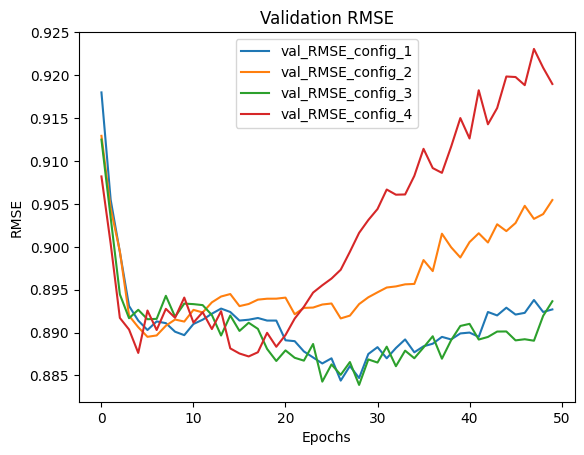

In [30]:
plt.plot(one,label='val_RMSE_config_1')
plt.plot(two,label='val_RMSE_config_2')
plt.plot(three,label='val_RMSE_config_3')
plt.plot(four,label='val_RMSE_config_4')

plt.title('Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show